In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
train = pd.read_csv("../../Data/Train.csv")
test = pd.read_csv("../../Data/Test.csv")

# Extract relevant columns
texts_train = train['text']
labels_train = train['label']
texts_test = test['text']
labels_test = test['label']

In [28]:
import numpy as np
from collections import defaultdict, Counter

def generate_ngrams(tokens, n):
    """Generate n-grams from a tokenized text."""
    return [tuple(tokens[i:i+n]) for i in range(len(tokens) - n + 1)]

def build_ngram_probabilities(texts, n, top_k=None):
    """
    Build an n-gram probability dictionary where:
    - Key = (first n-1 tokens)
    - Value = {next token: probability}
    """
    ngram_counts = defaultdict(Counter)

    # Count occurrences of each n-gram
    for text in texts:
        tokens = text.split()
        ngrams = generate_ngrams(tokens, n)
        for ngram in ngrams:
            prefix = ngram[:-1]  # First n-1 tokens
            next_token = ngram[-1]  # nth token
            ngram_counts[prefix][next_token] += 1  # Count occurrences

    # Convert counts to probabilities
    ngram_probs = {}
    for prefix, next_token_counts in ngram_counts.items():
        total = sum(next_token_counts.values())
        ngram_probs[prefix] = {token: count / total for token, count in next_token_counts.items()}

    # Keep only top-k n-grams if specified
    if top_k:
        for prefix in ngram_probs:
            sorted_probs = dict(sorted(ngram_probs[prefix].items(), key=lambda item: item[1], reverse=True)[:top_k])
            ngram_probs[prefix] = sorted_probs

    return ngram_probs

def build_multi_ngram_probabilities(texts, max_n, top_k=None):
    """Build dictionaries for multiple n-gram levels (bigram, trigram, etc.) using conditional probabilities."""
    return {n: build_ngram_probabilities(texts, n, top_k) for n in range(2, max_n + 1)}

def calculate_proxy_perplexity(text, ngram_probs, n):
    """
    Compute proxy perplexity for a given text using next-token probabilities:
    - Lower perplexity = More predictable text
    - Higher perplexity = Less predictable text
    """
    tokens = text.split()
    ngrams = generate_ngrams(tokens, n)
    total_log_prob = 0
    count = 0

    for ngram in ngrams:
        prefix = ngram[:-1]  # First n-1 tokens
        next_token = ngram[-1]  # nth token

        if prefix in ngram_probs and next_token in ngram_probs[prefix]:
            prob = ngram_probs[prefix][next_token]
            total_log_prob += np.log(prob)
            count += 1

    if count == 0:
        return 1e6  # Assign a large value if no n-grams match (high perplexity)

    return -total_log_prob / count

def calculate_multi_ngram_proxy_perplexity(text, ngram_dicts):
    """Compute proxy perplexities for multiple n-gram levels and return as a feature list."""
    return [calculate_proxy_perplexity(text, ngram_dict, n) for n, ngram_dict in ngram_dicts.items()]

### 3. TRAINING & FEATURE EXTRACTION ###

# Separate training texts by label
human_texts = texts_train[labels_train == 0]  # DM₀
ai_texts = texts_train[labels_train == 1]     # DM₁, DM₂, ..., DMc

# Create multi-n-gram probability dictionaries
max_n = 4  # Up to 4-grams
top_k = 5000  # Limit to top 5000 n-grams for storage efficiency

human_ngram_probs = build_multi_ngram_probabilities(human_texts, max_n, top_k)
ai_ngram_probs = build_multi_ngram_probabilities(ai_texts, max_n, top_k)

def prepare_multi_ngram_features(texts, human_dicts, ai_dicts):
    """Generate proxy perplexity features using both human and AI probability models."""
    features = []
    for text in texts:
        human_ppls = calculate_multi_ngram_proxy_perplexity(text, human_dicts)
        ai_ppls = calculate_multi_ngram_proxy_perplexity(text, ai_dicts)
        features.append(human_ppls + ai_ppls)  # Concatenate both feature sets
    return np.array(features)

# Prepare training and testing features
X_train = prepare_multi_ngram_features(texts_train, human_ngram_probs, ai_ngram_probs)
X_test = prepare_multi_ngram_features(texts_test, human_ngram_probs, ai_ngram_probs)

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

xgb     = XGBClassifier()
lgb     = LGBMClassifier()
cat     = CatBoostClassifier()
rfr     = RandomForestClassifier()
clf     = VotingClassifier(
    n_jobs=-1,
    voting='soft',
    estimators=[('xgb', xgb), ('lgb', lgb), ('cat', cat), ('rfr', rfr)]
).fit(X_train, labels_train)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [31]:
# Evaluate on the test set
y_pred = clf.predict(X_test)
print(classification_report(labels_test, y_pred))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
              precision    recall  f1-score   support

           0       0.74      0.55      0.63      5000
           1       0.64      0.81      0.71      5000

    accuracy                           0.68     10000
   macro avg       0.69      0.68      0.67     10000
weighted avg       0.69      0.68      0.67     10000



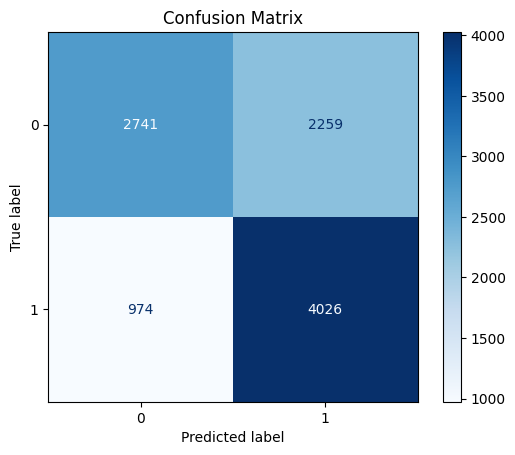

In [33]:
# Generate the confusion matrix
cm = confusion_matrix(test['label'], y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")  # Use a color map for visualization
plt.title("Confusion Matrix")
plt.show()
